In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import random

In [2]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);


In [11]:
folder = 'jpg'
folder_out = 'output'

imnames = [x for x in os.listdir(folder) if '.JPG' in x]  # get list of image files change .JPG is using files of different type

In [39]:
# PNG

folder = 'jpg'
folder_out = 'output'


imnames = [x for x in os.listdir(folder) if x.lower().endswith('.jpg')]

In [12]:
def checkcolour(masks, hsv):
    colours = np.zeros((0,3))

    for i in range(len(masks)):
        color = hsv[masks[i]['segmentation']].mean(axis=(0))
        colours = np.append(colours,color[None,:], axis=0)
        
    idx_green = (colours[:,0]<75) & (colours[:,0]>35) & (colours[:,1]>35)
    if idx_green.sum()==0:
        # grow lights on adjust
        idx_green = (colours[:,0]<100) & (colours[:,0]>35) & (colours[:,1]>35)
    
    return(idx_green)

In [13]:
def checkfullplant(masks):
    mask_all = np.zeros(masks[0]['segmentation'].shape[:2])

    for mask in masks:
        mask_all +=mask['segmentation']*1
        
    iou_withall = []
    for mask in masks:
        iou_withall.append(iou(mask['segmentation'], mask_all>0))
        
    idx_notall = np.array(iou_withall)<0.9
    return idx_notall

In [14]:
def getbiggestcontour(contours):
    nopoints = [len(cnt) for cnt in contours]
    return(np.argmax(nopoints))

def checkshape(masks):
    cratio = []

    for i in range(len(masks)):
        test_mask = masks[i]['segmentation']
        
        if not test_mask.max():
            cratio.append(0)
        else:

            contours,hierarchy = cv2.findContours((test_mask*255).astype('uint8'), 1, 2)

            # multiple objects possibly detected. Find contour with most points on it and just use that as object
            cnt = contours[getbiggestcontour(contours)]
            M = cv2.moments(cnt)

            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt,True)

            (x,y),radius = cv2.minEnclosingCircle(cnt)

            carea = np.pi*radius**2

            cratio.append(area/carea)
    idx_shape = np.array(cratio)>0.1
    return(idx_shape)

In [15]:
def iou(gtmask, test_mask):
    intersection = np.logical_and(gtmask, test_mask)
    union = np.logical_or(gtmask, test_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return (iou_score)

In [16]:
def issubset(mask1, mask2):
    # is mask2 subpart of mask1
    intersection = np.logical_and(mask1, mask2)
    return(np.sum(intersection)/mask2.sum()>0.9)

def istoobig(masks):
    idx_toobig = []
    
    mask_all = np.zeros(masks[0]['segmentation'].shape[:2])

    for mask in masks:
        mask_all +=mask['segmentation']*1 

    for idx in range(len(masks)):
        if idx in idx_toobig:
            continue
        for idx2 in range(len(masks)):
            if idx==idx2:
                continue
            if idx2 in idx_toobig:
                continue
            if issubset(masks[idx2]['segmentation'], masks[idx]['segmentation']):
                # check if actually got both big and small copy delete if do
                if mask_all[masks[idx2]['segmentation']].mean() > 1.5:
                
                    idx_toobig.append(idx2)
    
    idx_toobig.sort(reverse=True)        
    return(idx_toobig)

def remove_toobig(masks, idx_toobig):
    masks_ntb = masks.copy()

    idx_del = []
    for idxbig in idx_toobig[1:]:
        maskbig = masks_ntb[idxbig]['segmentation'].copy()
        submasks = np.zeros(maskbig.shape)

        for idx in range(len(masks_ntb)):
            if idx==idxbig:
                continue
            if issubset(masks_ntb[idxbig]['segmentation'], masks_ntb[idx]['segmentation']):
                submasks +=masks_ntb[idx]['segmentation']

        if np.logical_and(maskbig, submasks>0).sum()/maskbig.sum()>0.9:
            # can safely remove maskbig
            idx_del.append(idxbig)
            del(masks_ntb[idxbig])
            
    return(masks_ntb)

In [25]:
for imname in imnames:
    print(imname)
    image = cv2.imread(os.path.join(folder, imname))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,None,fx=0.5,fy=0.5)   # downsize image to fit on gpu easier may not be needed
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
           
    # use crop_n_layer=1 to improve results on smallest leaves 
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,
        pred_iou_thresh=0.88,
        stability_score_thresh=0.95,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=200,  
    )

    # get masks
    masks = mask_generator.generate(image)
    
    # remove things that aren't green enough to be leaves
    idx_green = checkcolour(masks,hsv)

    masks_g = []
    for idx, use in enumerate(idx_green):
        if use:
            masks_g.append(masks[idx])

    if len(masks_g) > 2:

        # check to see if full plant detected and remove
        idx_notall = checkfullplant(masks_g)

        masks_na = []

        for idx, use in enumerate(idx_notall):
            if use:
                masks_na.append(masks_g[idx])

    else:
        masks_na = masks_g

    idx_shape = checkshape(masks_na)

    masks_s = []
    for idx, use in enumerate(idx_shape):
        if use:
            masks_s.append(masks_na[idx])

    idx_toobig = istoobig(masks_s)
    masks_ntb = remove_toobig(masks_s, idx_toobig)
    
    # save results at each step as npz file 
    filename_base = os.path.splitext(imname)[0]
    save_path = os.path.join(folder_out, f"{filename_base}_leafonly_allmasks.npz")
    np.savez(save_path, masks, masks_g, masks_na, masks_s, masks_ntb)


self.jpg


In [43]:
def draw_mask_fill_resized(image, masks, original_size, alpha=0.5):
    output = image.copy()
    ih, iw = original_size

    overlay = np.zeros_like(image, dtype=np.uint8)

    for m in masks:
        mask = m["segmentation"].astype(np.uint8)
        resized_mask = cv2.resize(mask, (iw, ih), interpolation=cv2.INTER_NEAREST)

        # Генерируем случайный цвет
        color = [random.randint(0, 255) for _ in range(3)]
        
        # Применяем цвет к пикселям маски
        for c in range(3):  # по каналам RGB
            overlay[:, :, c][resized_mask == 1] = color[c]

    # Накладываем маски с прозрачностью
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    return output

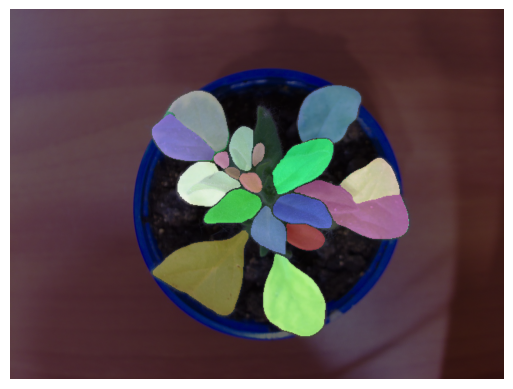

In [44]:
image = cv2.imread('jpg/self.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_size = image.shape[:2]

data = np.load('output/self_leafonly_allmasks.npz', allow_pickle=True)
masks_ntb = data['arr_4']

output = draw_mask_fill_resized(image, masks_ntb, original_size, alpha=0.6)

plt.imshow(output)
plt.axis('off')
plt.show()


In [20]:
import matplotlib.pyplot as plt
import random

# Создаем изображение для отображения результатов
vis_image = image.copy()

# Сюда будем рисовать цветные маски
overlay = np.zeros_like(image, dtype=np.uint8)

for mask in masks_ntb:
    seg = mask['segmentation']  # это булев массив той же формы, что изображение

    # Случайный цвет
    color = [random.randint(0, 255) for _ in range(3)]

    # Наложим цвет на маску
    overlay[seg] = color

# Прозрачное наложение масок на оригинал
alpha = 0.5
vis_combined = cv2.addWeighted(vis_image, 1 - alpha, overlay, alpha, 0)
vis_combined_small = cv2.resize(vis_combined, (0, 0), fx=0.5, fy=0.5)

# Сохранение или отображение
out_vis_path = os.path.join(folder_out, f"{filename_base}_vis.png")
cv2.imwrite(out_vis_path, cv2.cvtColor(vis_combined_small, cv2.COLOR_RGB2BGR))

# Также можно отобразить с помощью matplotlib:
# plt.imshow(vis_combined)
# plt.axis("off")
# plt.show()


IndexError: boolean index did not match indexed array along axis 0; size of axis is 1000 but size of corresponding boolean axis is 500